# Construyendo modelo de clasificación usando `Suppoer Vector Machine`

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Enero de 2026  
**Versión:** 1.0  


---

## Descripción

Este notebook muestra la construcción de un modelo predictivo de una variable discreta, es decir, un `modelo de clasificación`.

El algoritmo usado es `Support Vector Machine` para clasificación, `SVC`. Acá lo *relevante* es elegir, correctamente, el kernel a aplicar.

Se automatizan la fases de preparación y modelado a través del uso de `pipeline de scikit-learn`

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.12. A continuación se listan las bibliotecas necesarias:

- pandas (2.2.2)
- numpy (2.0.2)
- sklearn (1.6.1)
- matplotlib (3.10.0)

Para verificar si está instalado pandas, numpy o matplotlib ejecutar:

```bash
pip show pandas
```

```bash
pip show numpy
```

Para verificar las versiones, ejecutar:

```python
import sklearn
import matplotlib

print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
```

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, silhouette_score

In [3]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.05, 0.05)):
        self.limits = limits

    def fit(self, X, y=None):
        # Guardar nombres si es DataFrame, si no generar nombres genéricos
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
        else:
            self.columns_ = np.arange(X.shape[1])
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns_)
        for col in self.columns_:
            lower = X[col].quantile(self.limits[0])
            upper = X[col].quantile(1 - self.limits[1])
            X[col] = np.clip(X[col], lower, upper)
        return X.values

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns_)
        else:
            return np.array(input_features)

## Generación de conjunto de datos

In [4]:
# Crear un dataset simple (simulado)
np.random.seed(29)
n = 100
horas_estudio = np.random.uniform(1, 10, n)
horas_sueno = np.random.uniform(4, 10, n)

# Variable dependiente: aprobar (1) o reprobar (0)
# Cuantas más horas estudie y duerma bien, mayor chance de aprobar
prob_aprob = 1 / (1 + np.exp(-(0.8*horas_estudio + 0.4*horas_sueno - 7)))
aprobado = np.random.binomial(1, prob_aprob)

data = pd.DataFrame({
    'Horas_estudio': horas_estudio,
    'Horas_sueno': horas_sueno,
    'Aprobado': aprobado
})

In [ ]:
data.head()

,Horas_estudio,Horas_sueno,Aprobado
0,8.773840,9.994662,1
1,3.564154,8.401086,1
2,1.659307,8.530421,0
3,7.869135,7.321440,1
4,5.074472,7.472667,1


In [18]:
data.dtypes

,0
Horas_estudio,float64
Horas_sueno,float64
Aprobado,int64


In [19]:
# Pasa a categórica la variable objetivo
data['Aprobado'] = data['Aprobado'].astype('category')

## Separación de variables

In [20]:
# Separar variables predictoras y objetivo
X = data[['Horas_estudio', 'Horas_sueno']]
y = data['Aprobado']

In [21]:
# Distribución de la variable objetivo
y.value_counts()

,count
Aprobado,
1,55
0,45


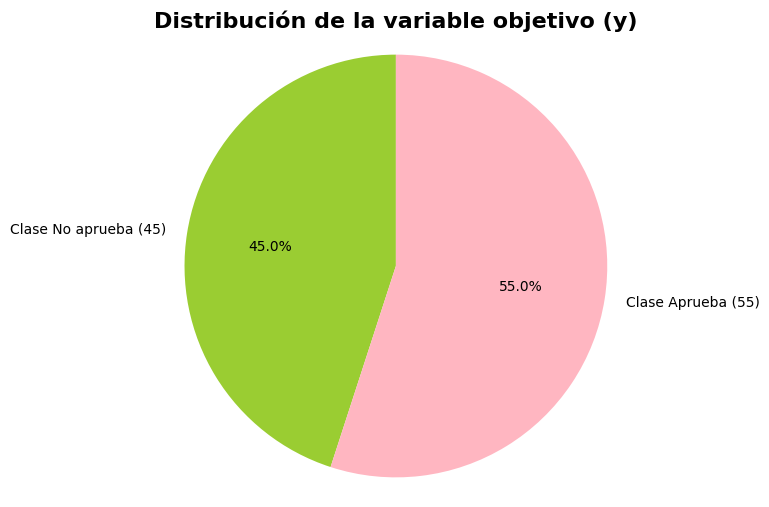

In [22]:
# Calcular proporciones por clase
clases, counts = np.unique(y, return_counts=True)
labels = [f"Clase {'No aprueba' if clases[i]==0 else 'Aprueba'} ({counts[i]})" for i in range(len(clases))]
colors = ["#9ACD32", "#FFB6C1"]

# Crear gráfico de torta
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct="%1.1f%%", startangle=90, colors=colors)
plt.title("Distribución de la variable objetivo (y)", fontsize=16, fontweight="bold")
plt.axis("equal")
plt.show()

## Determina el tipo de kernel a usar

In [23]:
silhouette_avg = silhouette_score(X, y)
print(f"Índice de Silhouette: {silhouette_avg : .4f}")

Índice de Silhouette:  0.2517


In [52]:
def plot_data(X : np.array, y : np.array, labels : np.array, title="Distribución de los datos") -> None:
  """
  Genera gráfico para ver la distribución de los datos

  Parámetros:
  ----------
  - X: Matriz de características
  - y: Etiquetas de clase
  - labels: Etiquetas de clase
  - title: Título del gráfico

  Retorna:
  --------
  - None
  """
  plt.figure(figsize=(8, 6))
  for label in np.unique(y):
    plt.scatter(X[y == label, 0], X[y == label, 1], label=f"{labels[label]}", alpha=0.8)
  plt.title(title, fontsize=14, fontweight="bold")
  plt.xlabel("Horas estudio", fontsize=12, fontweight="bold")
  plt.ylabel("Horas sueño", fontsize=12, fontweight="bold")
  plt.legend()
  plt.show()

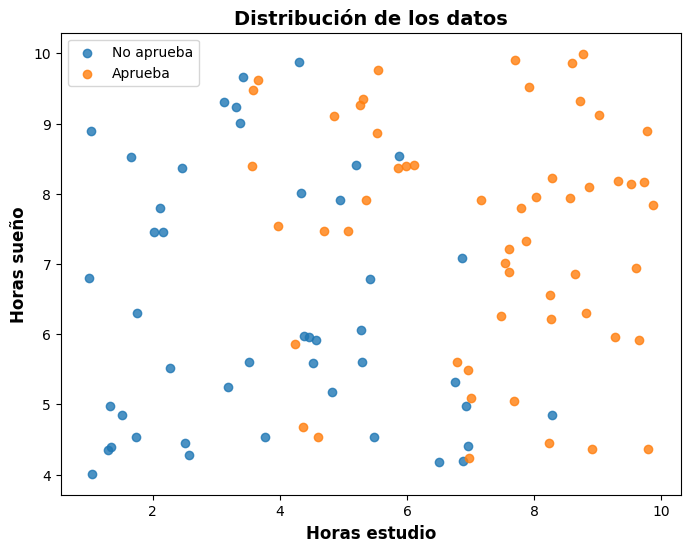

In [53]:
# Gráfica de la distribución
plot_data(X.values, y.values, ['No aprueba', 'Aprueba'])

**Conclusiones**

+ Dado que, visualmente y usando el índice de la sileta (cercano a cero), se evidencia la inexistencia de `separación lineal` se sugiere el uso de un `kernel NO lineal`

## Obtención de datos de entranemiento y prueba

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29,
                                                    stratify=y)

70% train y 30% test

75% train y 25% test

80% train y 20% test

## Creación del modelo

In [43]:
# Construir un pipeline: tratamiento atípicos + imputación + Escalado + SVM
modelo = Pipeline([
    ('winsorizer', Winsorizer()),
    ("imputer", SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel="rbf"))
])

## Entrenamiento del modelo

In [44]:
# Entrenar el modelo
modelo.fit(X_train, y_train)

Pipeline(steps=[('winsorizer', Winsorizer()), ('imputer', SimpleImputer()),
                ('scaler', StandardScaler()), ('classifier', SVC())])

## Evaluación del modelo

In [45]:
# Evaluar el modelo
y_pred = modelo.predict(X_test)

### Cálculo de métricas

In [46]:
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No aprueba', 'Aprueba']))


Reporte de Clasificación:
              precision    recall  f1-score   support

  No aprueba       0.78      0.54      0.64        13
     Aprueba       0.71      0.88      0.79        17

    accuracy                           0.73        30
   macro avg       0.75      0.71      0.71        30
weighted avg       0.74      0.73      0.72        30



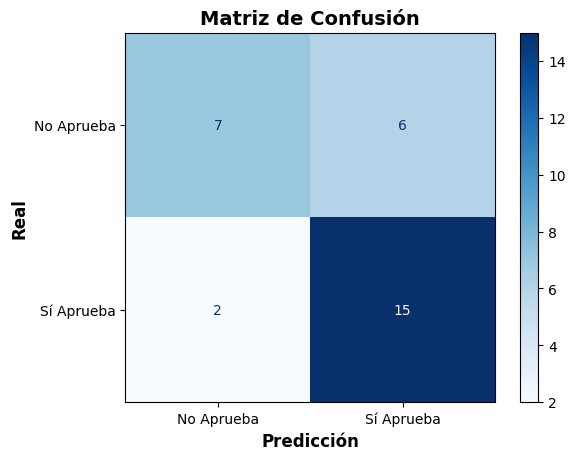

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=["No Aprueba", "Sí Aprueba"],
                                        cmap="Blues")
plt.title("Matriz de Confusión", fontsize=14, fontweight="bold")
plt.xlabel("Predicción", fontsize=12, fontweight="bold")
plt.ylabel("Real", fontsize=12, fontweight="bold")
plt.show()

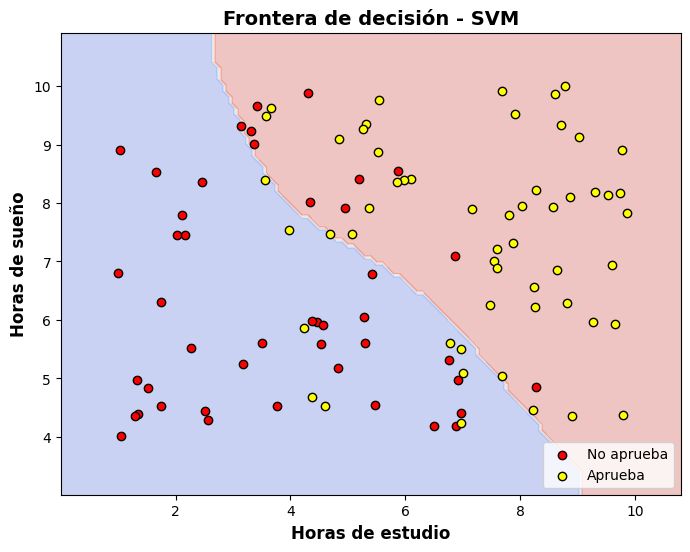

In [54]:
# Visualización (frontera de decisión)
x_min, x_max = X['Horas_estudio'].min()-1, X['Horas_estudio'].max()+1
y_min, y_max = X['Horas_sueno'].min()-1, X['Horas_sueno'].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Crear el DataFrame con nombres de columnas
grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()],
                    columns=['Horas_estudio', 'Horas_sueno'])

Z = modelo.predict(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
# Dibujar los puntos de datos con las etiquetas
for clase, color, label in zip([0,1], ['#FF0000','#FFFF00'],
                               ['No aprueba', 'Aprueba']):
    plt.scatter(
        X.loc[y==clase, 'Horas_estudio'],
        X.loc[y==clase, 'Horas_sueno'],
        c=color,
        edgecolors='k',
        label=label
    )
plt.xlabel('Horas de estudio', fontsize=12, fontweight="bold")
plt.ylabel('Horas de sueño', fontsize=12, fontweight="bold")
plt.title('Frontera de decisión - SVM', fontsize=14, fontweight="bold")
plt.legend(loc='lower right')
plt.show()
